In [119]:
from astropy.table import Table
import numpy as np
from scipy import interpolate
from scipy.optimize import curve_fit
from astropy.io import ascii
import matplotlib.pyplot as plt
# from scipy.integrate import quad

# Time range around the horizon crossing
startTime = 390+1.92224*10**8
stopTime = 500+1.92224*10**8

# indices of full crossing
startTimeIndex = 311869
stopTimeIndex = 449115

startMKF = 2264 - 15
stopMKF = 2374 + 184

# read in the data files
tab_ni = Table.read('ni2200300102.mkf', hdu=1)
timeArray = np.array(tab_ni['TIME'][startMKF:stopMKF])
elevArray = np.array(tab_ni['ELV'][startMKF:stopMKF])
azArray = np.array(tab_ni['RAM_ANGLE'][startMKF:stopMKF])

tab_evt = Table.read('cleanfilt.evt', hdu=1)
eventTime = np.array(tab_evt['TIME'][startTimeIndex:stopTimeIndex])
enArray = np.array(tab_evt['PI'][startTimeIndex:stopTimeIndex])


# interpolate the times.evt to go over the range of elevations.mkf
f = interpolate.interp1d(timeArray, elevArray, kind='linear')
elev_evt = f(eventTime)

g = interpolate.interp1d(timeArray, azArray, kind='linear')
az_evt = g(eventTime)

# calculate altitude based on elevation angle
R = 6378
H = 419
theta = np.arcsin(R/(R+H))
altArray = []
for indx, val in enumerate(elev_evt):
    h = ((R+H)*np.sin(theta+val*(np.pi/180)))-R
    altArray.append(np.float(h))
altArray = np.array(altArray)


# read in MSIS model data
data = ascii.read("msis_419.txt")

height = np.array(data['h'])
density = np.array(data['dens'])
temp = np.array(data['T'])


def msisSync(Y_msis):
    height[0] = altArray[0]
    height[len(height)-1] = altArray[len(altArray)-1]
    func = interpolate.interp1d(height, Y_msis)
    return np.array(func(altArray))


msisRho = msisSync(density)
msisT = msisSync(temp)


#constants
binSize_all = 1
k = 1.38064852e-23
mu = 28
mp = 1.6726219e-27
g = 9.8
intStepSize = .2


class EnergyBands:

    def __init__(self, energy_band, bin_size):
        self.energy_band = energy_band
        self.bin_size = bin_size
        self.time, self.energies = EnergyBands.enSplit(self)
        self.alt = EnergyBands.altSplit(self)
        self.rate, self.new_alt, self.binTime = EnergyBands.countRate(self)
        self.T_pre = EnergyBands.msisSplit(self, msisT)
        self.rho_pre = EnergyBands.msisSplit(self, msisRho)
        self.rho_msis, self.T_msis = EnergyBands.countRateSync(self)
        self.perc_trans = EnergyBands.percTrans(self)
        self.L_msis = EnergyBands.atmHeight(self)



    # function that splits the altitudes based on energy bands
    def altSplit(self):
        index = np.where((enArray >= self.energy_band[0]) & (
            enArray < self.energy_band[1]))
        return altArray[index[0]]


    # function that deduces the number of counts per bin size
    def countRate(self):
        binCounts = []
        binTime = []
        altitude = []
        for i in np.arange(min(self.time), max(self.time)+self.bin_size, self.bin_size):
            desind = np.where((self.time >= i) & (self.time < i + self.bin_size))
            if len(self.alt[desind[0]]) != 0:
                binCounts.append(np.size(desind[0]))
                altitude.append(np.mean(self.alt[desind[0]]))
                binTime.append(np.mean(self.time[desind[0]]))
        return np.array(binCounts), np.array(altitude), np.array(binTime)


    def countRateSync(self):
        rho = []
        temp = []
        for i in np.arange(min(self.time), max(self.time)+self.bin_size, self.bin_size):
            desind = np.where((self.time >= i) & (self.time < i + self.bin_size))
            if len(self.alt[desind[0]]) != 0.:
                rho.append(np.mean(self.rho_pre[desind[0]]))
                temp.append(np.mean(self.T_pre[desind[0]]))
        return np.array(rho), np.array(temp)


    # function that makes a list of times corresponding to each energy range
    def enSplit(self):
        index = np.where((enArray >= self.energy_band[0]) & (
            enArray < self.energy_band[1]))
        return eventTime[index[0]], enArray[index[0]]/100


    def percTrans(self):
        plateau = np.where(((self.new_alt > 200) & (self.new_alt < 250)))
        avg = np.mean(self.rate[plateau[0]])
        return (self.rate/avg)*100


    # functions to make the atmospheric model
    # altArray=h in mathematica


    def atmHeight(self):
        return np.array((k*self.T_msis)/(1000*mu*mp*g))


    def Sigma(self):
        c = np.float(-3)
        return (3.31*10**3)*(np.mean(self.energies)/100)**c


    def msisSplit(self, msis_col):
        index = np.where((enArray >= self.energy_band[0]) & (enArray < self.energy_band[1]))
        return msis_col[index[0]]

    
    @property
    def altError(self):
        alt_error = []
        for i in range(len(all_en.new_alt)):
            frac_sigma = np.sqrt(self.rate[i])/self.rate[i]
            alt_error.append(frac_sigma*self.new_alt[i])
        return alt_error
    
    
    @property
    def modelDensity(self):
        numInt = []
        A = []
        T = []
        Rho_zdz = []
        Rho_z = []
        f = 0
        for alt in np.arange(0,len(self.altExtend),1):
            i = alt - 1
            A.append((self.altExtend[i]**2)*(k/(g*mu*mp)))
            T.append(self.tempExtend[i])
        
        T.insert(len(T),T.pop(0))
     
        upperIndex = len(self.altExtend) - 1
        index_zdz = len(self.altExtend) - 1
        index_z = len(self.altExtend) - 2
        
        for indx in np.arange(len(self.altExtend),0,-1):

            if (indx == len(self.altExtend)):
                f = 0
                rho0 = self.rho_msis[len(self.rho_msis)-1]
                loops = upperIndex - index_zdz
                for i in range(loops):
                    f += intStepSize * rho0 * self.altExtend[index_zdz+i]**2
                numInt.append(f)
                Rho_z.append((((numInt[0]/A[0])+T[0]*rho0))/T[0])
                index_zdz -= 1
                index_z -= 1
                
            
            elif (index_z > 0):
                f = 0
                loops = upperIndex - index_zdz
                for i in range(loops):
                    rho0 = Rho_z[i]
                    f += intStepSize * rho0 * self.altExtend[index_zdz+i]**2
                numInt.append(f)
                Rho_z.append((((numInt[len(numInt)-1]/A[index_zdz])+T[index_zdz]*Rho_z[len(Rho_z)-1]))/T[index_z])
                index_zdz -= 1
                index_z -= 1
                
            else:
                f = 0
                loops = upperIndex - index_zdz
                for i in range(loops):
                    rho0 = Rho_z[i]
                    f += intStepSize * rho0 * self.altExtend[index_zdz+i]**2
                numInt.append(f)
                Rho_z.append((((numInt[len(numInt)-1]/A[len(A)-1])+T[len(T)-1]*Rho_z[len(Rho_z)-1]))/T[len(T)-2])
                index_zdz -= 1
                index_z -= 1
            
        numInt.reverse()
        Rho_z.reverse()
        return np.array(Rho_z)
    
    
    @property
    def modelDensityError(self):
        numInt = []
        A = []
        T = []
        Rho_zdz = []
        Rho_z = []
        f = 0
        for alt in np.arange(0,len(self.altError),1):
            i = alt - 1
            A.append((self.altError[i]**2)*(k/(g*mu*mp)))
            T.append(self.T_msis[i])
        
        T.insert(len(T),T.pop(0))
     
        upperIndex = len(self.altError) - 1
        index_zdz = len(self.altError) - 1
        index_z = len(self.altError) - 2
        
        for indx in np.arange(len(self.altError),0,-1):

            if (indx == len(self.altError)):
                f = 0
                rho0 = self.rho_msis[len(self.rho_msis)-1]
                loops = upperIndex - index_zdz
                for i in range(loops):
                    f += intStepSize * rho0 * self.altError[index_zdz+i]**2
                numInt.append(f)
                Rho_z.append((((numInt[0]/A[0])+T[0]*rho0))/T[0])
                index_zdz -= 1
                index_z -= 1
                
            
            elif (index_z > 0):
                f = 0
                loops = upperIndex - index_zdz
                for i in range(loops):
                    rho0 = Rho_z[i]
                    f += intStepSize * rho0 * self.altError[index_zdz+i]**2
                numInt.append(f)
                Rho_z.append((((numInt[len(numInt)-1]/A[index_zdz])+T[index_zdz]*Rho_z[len(Rho_z)-1]))/T[index_z])
                index_zdz -= 1
                index_z -= 1
                
            else:
                f = 0
                loops = upperIndex - index_zdz
                for i in range(loops):
                    rho0 = Rho_z[i]
                    f += intStepSize * rho0 * self.altError[index_zdz+i]**2
                numInt.append(f)
                Rho_z.append((((numInt[len(numInt)-1]/A[len(A)-1])+T[len(T)-1]*Rho_z[len(Rho_z)-1]))/T[len(T)-2])
                index_zdz -= 1
                index_z -= 1
            
        numInt.reverse()
        Rho_z.reverse()
        return np.array(Rho_z)
    
    
    @property
    def altExtend(self):
        X = np.arange(min(self.new_alt),max(self.new_alt),intStepSize)
        return X
    
    
    @property
    def tempExtend(self):
        X = np.arange(min(self.altExtend),max(self.altExtend),intStepSize)
        function = interpolate.interp1d(self.new_alt, self.T_msis, fill_value='extrapolate')
        return function(X)
    
    
    @property
    def shortModelDensity(self):
        interpFunc = interpolate.interp1d(all_en.altExtend, all_en.modelDensity,fill_value='extrapolate')
        return interpFunc(self.new_alt)
    
    
    @property
    def shortDensityError(self):
        func = interpolate.interp1d(self.altError, self.modelDensityError, fill_value='extrapolate')
        return func(self.new_alt)
    
    
    @property
    def density_residuals(self):
        return self.shortModelDensity - self.rho_msis
    
    
    @property
    def numberOfSigma(self):
        return abs(self.density_residuals/self.shortDensityError)
        

In [120]:
allEn = [0, 600]

all_en = EnergyBands(allEn, binSize_all)

Power_divergenceResult(statistic=6.5427527950565105, pvalue=1.0)


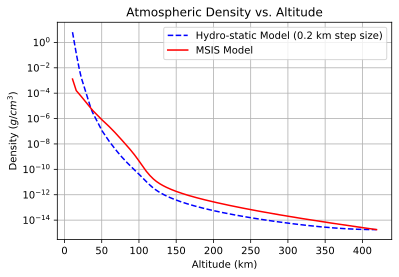

In [127]:
%config InlineBackend.figure_format = 'svg'
plt.plot(all_en.new_alt, all_en.shortModelDensity, 'b--', label = f'Hydro-static Model ({intStepSize} km step size)')
plt.plot(all_en.new_alt, all_en.rho_msis, 'r-', label = 'MSIS Model')
plt.yscale('log')
plt.title('Atmospheric Density vs. Altitude')
plt.xlabel('Altitude (km)')
plt.ylabel(r'Density ($g/cm^3$)')
plt.legend()
plt.grid()
from scipy.stats import chisquare
print(chisquare(all_en.rho_msis, all_en.shortModelDensity))

In [130]:
print(chisquare(all_en.rho_msis[4:len(all_en.rho_msis)-1], all_en.shortModelDensity[4:len(all_en.rho_msis)-1]))

Power_divergenceResult(statistic=1.0919441191102191e-05, pvalue=1.0)
-6.397137776277295


In [131]:
print(all_en.rho_msis[0]-all_en.shortModelDensity[0])

-6.397137776277295


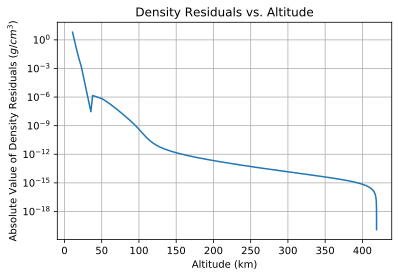

In [128]:
%config InlineBackend.figure_format = 'svg'
plt.plot(all_en.new_alt, abs(all_en.density_residuals))
#plt.xlim(20,420)
plt.yscale('log')
plt.title('Density Residuals vs. Altitude')
plt.xlabel('Altitude (km)')
plt.ylabel(r'Absolute Value of Density Residuals ($g/cm^3$)')
plt.grid()

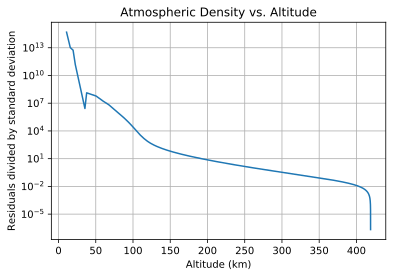

In [126]:
plt.plot(all_en.new_alt, all_en.numberOfSigma)
plt.yscale('log')
plt.title('Atmospheric Density vs. Altitude')
plt.xlabel('Altitude (km)')
plt.ylabel('Residuals divided by standard deviation')
plt.grid()

Power_divergenceResult(statistic=43.57612720129648, pvalue=1.0)


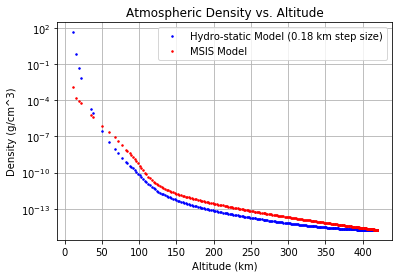

In [114]:
plt.plot(all_en.new_alt, all_en.shortModelDensity, 'b.', markersize = '3', label = f'Hydro-static Model ({intStepSize} km step size)')
plt.plot(all_en.new_alt, all_en.rho_msis, 'r.', markersize = '3', label = 'MSIS Model')
plt.yscale('log')
plt.title('Atmospheric Density vs. Altitude')
plt.xlabel('Altitude (km)')
plt.ylabel('Density (g/cm^3)')
plt.legend()
plt.grid()
from scipy.stats import chisquare
print(chisquare(all_en.rho_msis, all_en.shortModelDensity))

In [118]:
print(chisquare(all_en.rho_msis[4:len(all_en.rho_msis)-1], all_en.shortModelDensity[4:len(all_en.rho_msis)-1]))

Power_divergenceResult(statistic=1.508851371868488e-05, pvalue=1.0)
